<img src="https://www.juliahomotopycontinuation.org/images/logo_transparent_bg.png" style="height:140px;"/>


[HomotopyContinuation.jl](https://www.juliahomotopycontinuation.org) is package for the numerical solution of systems of polynomial equations.
In this notebook we give an overview over some of the features of **HomotopyContinuation.jl** with examples coming from a range of applications in nonlinear algebra.

To find out more about **HomotopyContinuation.jl** (including documentation, guides and more examples) take a look at our homepage <a href="https://www.juliahomotopycontinuation.org">JuliaHomotopyContinuation.org</a>.

The notebook contains several examples. Feel free to take a look at any subset of them.
* **[A simple example](#A-simple-example)**
* **[Tritangents to a quartic surface](#Tritangents-to-a-quartic-surface)**
* **[The bottlenecks of an algebraic variety](#The-bottlenecks-of-an-algebraic-variety)**
* **[Steiner's conic problem](#Steiner's-conic-problem)**
* **[Gaussian mixtures and the method of moments](#Gaussian-mixtures-and-the-method-of-moments)**
* **[The degree of Stiefel manifolds](#The-degree-of-Stiefel-manifolds)**
* **[Tritangent planes to a quartic surface](#Tritangent-planes-to-a-quartic-surface)**
* **[Witness sets](#Witness-sets)**

# Installation of notebook

### Requirements

You need to have **Julia 1.4** installed and internet access (to install the packages).
[Here](https://www.juliahomotopycontinuation.org/guides/installation/) is an installation guide.
To install the Julia Jupyter notebook kernel you have to install the `IJulia.jl` package.
This can be done as follows in running Julia session:
```julia
using Pkg
Pkg.add("IJulia")
```

### Instantiating

This notebook is accompanied by two files: `Project.toml` and `Manifest.toml`. The `Project.toml` lists all packages necessary to run this notebook and the `Manifest.toml` records a working set of all (transitive) dependcies for which this notebook worked for me.
You can install an identical copy of my environment by executing

In [21]:
import Pkg
Pkg.instantiate()

**Note:** This notebook is written for HomotopyContinuation.jl **2.0** which was only recently released.

# A simple example

We are interested in the numerical solution of systems of polynomial equations like
$$\begin{array}{rl} -x^5y &= (x^4 + y^4 - 1)(x^2 + y^2 - 2) \\\\ \frac12 &=  x^2+2xy^2 - 2y^2 . \end{array}$$

Equivalently, we can see the solutions of this system of equations as the common zero set $V(f_1,f_2)$ of the polynomials
$$
    f_1(x,y) = (x^4 + y^4 - 1)(x^2 + y^2 - 2)  + x^5y \quad \text{ and } \quad f_2(x,y) =  x^2+2xy^2 - 2y^2 - \frac12 .
$$
The common zero set $V(f_1,f_2)$ is also called a *variety*.

<figure>
<p style="text-align:center;">
<img alt="simple-example" src="https://www.juliahomotopycontinuation.org/images/simple-example.png" style="height:400px"/>
</p>
    <figcaption style="text-align: center;" >The zero set of $f_1$ in <span style="color:steelblue">blue</span> and the zero set of $f_2$ in <span style="color:indianred">red</span>. Their common zero set is depicted in <span style="color:black">black</span>.</figcaption>

</figure>


From the figure we can see that $f_1$ and $f_2$ have 4 common zeros.

Let's compute them.

In [84]:
using HomotopyContinuation

# declare variables x and y
@var x y

# define the polynomials
f₁ = (x^4 + y^4 - 1) * (x^2 + y^2 - 2) + x^5 * y
f₂ = x^2+2x*y^2 - 2y^2 - 1/2
# declare the system
F = System([f₁, f₂])

System of length 2
 2 variables: x, y

 x^5*y + (-2 + x^2 + y^2)*(-1 + x^4 + y^4)
 -0.5 + 2*x*y^2 + x^2 - 2*y^2

Now we can use the blackbox `solve` routine to compute the isolated solutions of $F(x,y) = 0$.

In [90]:
result = solve(F)

Result with 18 solutions
• 18 paths tracked
• 18 non-singular solutions (4 real)
• random_seed: 0x8671c247
• start_system: :polyhedral


Now, the result reports that we found **18** solutions and **4  real** solutions. Why do we have 14 solutions more than expected? The reason is that we do not compute the common zero set of $f_1$ and $f_2$ over the real numbers, but over the **complex numbers**. Although there are usually more complex solutions than real solutions, this makes the problem of computing all real solutions *much* easier.

> The shortest path between two truths in the real domain passes through the complex domain.
> -- <cite>J. Hadamard</cite>

We can extract the coordinates of the four real solutions from the `result`

In [94]:
real_solutions(result)

4-element Array{Array{Float64,1},1}:
 [-1.671421392838003, 0.6552051858720408]
 [-0.9368979667963298, 0.31228408173860095]
 [0.8209788924342627, -0.6971326459489458]
 [0.8999179208471728, -1.2441827613422727]

Note that the "realness" of these 4 solutions is here only determined heuristically. However, we could also certify this.

In [96]:
certify(F, result)

CertificationResult
• 18 solutions given
• 18 certified solutions (4 real)
• 18 distinct certified solutions (4 real)

# The bottlenecks of an algebraic variety

<figure>
<img src="https://www.juliahomotopycontinuation.org/images/curve_reach_bottlenecks.png" style="width:400px;display: block;margin-left: auto;margin-right: auto;">
<figcaption style="text-align:center; color:gray;">
A place curve and its bottlenecks dashed in gray. The narrowest bottleneck is colored <span style="color:tomato">red</span>.
</figcaption>
</figure>


Bottlenecks of of an algebraic variety $X = V(f)$ are pairs of points $(x,y) \in X\times X$, $x \ne y$, such that $x-y$ is in the normal space $\mathrm{N}_x X$ and in the normal space $\mathrm{N}_y X$.
[Eklund](https://arxiv.org/abs/1804.01015) and [di Rocco et. al.](https://arxiv.org/abs/1904.04502) discuss the algebraic equations of bottlenecks. For an hypersurface given by $f=0$ the equations are

$$f(x) = 0, \quad \nabla f(x) \lambda = x - y, \quad f(y) = 0,\quad \nabla f(y) \mu = x - y$$

where $\nabla f(x)$ denotes the [gradient](https://en.wikipedia.org/wiki/Gradient) of $f$ at $x$ and $\lambda$ and $\mu$ are additional variables. The first equation defines $x\in X$ and the second equation defines $x-y \in \mathrm{N}_x X$. The third equation defines $y\in X$ and the fourth equation defines $x-y \in \mathrm{N}_y X$.

Additionally, we want to enforce the condition $x \ne y$. Algebraically, this corresponds to saturating the ideal with respect to $\prod_i (x_i -y_i)$. We can accomplish this by having the additional equation
$$s \prod_i (x_i -y_i) - 1\,.$$

Here is the code to formulate the system in HomotopyContinuation.jl.

In [124]:
using HomotopyContinuation
@var x[1:2]
f = (x[1]^3 - x[1]*x[2]^2 + x[2] + 1)^2 * (x[1]^2 + x[2]^2 - 1) + x[2]^2 - 5

bn_system = let
    @var y[1:2] λ μ s v[1:2]
    ∇f = differentiate(f, x)
    System([
        f
        ∇f * λ - (x - y)
        f(x => y)
        ∇f(x => y) * μ - (x - y)
        s * (prod(x - y)) - 1
    ]; variables = [x; y; λ; μ; s])
end

System of length 7
 7 variables: x₁, x₂, y₁, y₂, λ, μ, s

 -5 + (-1 + x₁^2 + x₂^2)*(1 + x₂ - x₂^2*x₁ + x₁^3)^2 + x₂^2
 λ*(2*x₁*(1 + x₂ - x₂^2*x₁ + x₁^3)^2 + 2*(3*x₁^2 - x₂^2)*(-1 + x₁^2 + x₂^2)*(1 + x₂ - x₂^2*x₁ + x₁^3)) - (x₁ - y₁)
 λ*(2*x₂ + 2*x₂*(1 + x₂ - x₂^2*x₁ + x₁^3)^2 + 2*(-1 + x₁^2 + x₂^2)*(1 + x₂ - x₂^2*x₁ + x₁^3)*(1 - 2*x₂*x₁)) - (x₂ - y₂)
 -5 + (-1 + y₁^2 + y₂^2)*(1 + y₂ - y₁*y₂^2 + y₁^3)^2 + y₂^2
 μ*(2*y₁*(1 + y₂ - y₁*y₂^2 + y₁^3)^2 + 2*(-1 + y₁^2 + y₂^2)*(3*y₁^2 - y₂^2)*(1 + y₂ - y₁*y₂^2 + y₁^3)) - (x₁ - y₁)
 μ*(2*y₂ + 2*y₂*(1 + y₂ - y₁*y₂^2 + y₁^3)^2 + 2*(-1 + y₁^2 + y₂^2)*(1 + y₂ - y₁*y₂^2 + y₁^3)*(1 - 2*y₁*y₂)) - (x₂ - y₂)
 -1 + s*(x₁ - y₁)*(x₂ - y₂)

Now, we can pass the system to `solve` to compute it's solutions.

In [111]:
bottleneck_result = solve(bn_system)

Tracking 3600 paths... 100%|████████████████████████████| Time: 0:00:03
  # paths tracked:                  3600
  # non-singular solutions (real):  1726 (104)
  # singular endpoints (real):      0 (0)
  # total solutions (real):         1726 (104)


Result with 1726 solutions
• 3600 paths tracked
• 1726 non-singular solutions (104 real)
• random_seed: 0xd4926db1
• start_system: :polyhedral


We see that we find $1726$ solutions of which $104$ are real. Let's extract the x and y coordinates of those 104 solutions.

In [114]:
bn_real_solutions = map(x -> x[1:4], real_solutions(bottleneck_result))

104-element Array{Array{Float64,1},1}:
 [0.7825029522761754, 1.489379650889989, 0.8380646154550541, 1.6160838973346432]
 [1.1727790894167083, 2.079548084019588, 0.9785760124466275, -1.3767262787162167]
 [-0.6851397617457625, -1.6953936841180695, 1.7889119199177603, 2.2353101573649563]
 [0.8051038425888838, 1.6493132196797127, 1.7897879294281294, 2.234430974012365]
 [0.8879431408206833, -1.3763863660933688, 0.7510886854338582, 1.4942776321034474]
 [-0.8752973020567416, 1.0128271793465617, -0.24577322542521296, -2.2356250461941105]
 [-0.7450302592028445, -1.6620936795974433, 0.7844050532614113, 1.488501299376511]
 [0.8090380570229553, 1.4673626566954847, 1.7896119628546143, 2.2346881132415044]
 [1.249273301132837, 0.034496023798154876, -1.4349379845123864, -0.23066233904808647]
 [1.7884992969474989, 2.2355321564460655, -0.26164294961659484, -2.233441781967787]
 [0.8624201877461506, 1.611647850351416, 0.9148150341636954, -1.375508721873141]
 [0.8443605974629239, 1.6138173164101104, -0.257

You may have noticed that our polynomial system actually overcounts the number of bottlenecks by a factor of 2. Namely, for each bottleneck pair $(x,y) \in X \times X$ also $(y, x) \in X \times X$ is a solution, but they represent the same bottleneck. We can eliminate them by using the `unique_points` function

In [116]:
# declare that a solution x,y is identical to a solution y,x
switch = xy -> [xy[3:4];xy[1:2]]
bottlenecks = unique_points(bn_real_solutions, group_action = switch)

52-element Array{Array{Float64,1},1}:
 [0.7825029522761754, 1.489379650889989, 0.8380646154550541, 1.6160838973346432]
 [1.1727790894167083, 2.079548084019588, 0.9785760124466275, -1.3767262787162167]
 [-0.6851397617457625, -1.6953936841180695, 1.7889119199177603, 2.2353101573649563]
 [0.8051038425888838, 1.6493132196797127, 1.7897879294281294, 2.234430974012365]
 [0.8879431408206833, -1.3763863660933688, 0.7510886854338582, 1.4942776321034474]
 [-0.8752973020567416, 1.0128271793465617, -0.24577322542521296, -2.2356250461941105]
 [-0.7450302592028445, -1.6620936795974433, 0.7844050532614113, 1.488501299376511]
 [0.8090380570229553, 1.4673626566954847, 1.7896119628546143, 2.2346881132415044]
 [1.249273301132837, 0.034496023798154876, -1.4349379845123864, -0.23066233904808647]
 [1.7884992969474989, 2.2355321564460655, -0.26164294961659484, -2.233441781967787]
 [0.8624201877461506, 1.611647850351416, 0.9148150341636954, -1.375508721873141]
 [0.8443605974629239, 1.6138173164101104, -0.2572

Now let's visualize our bottlenecks in order to see whether we didn't make any mistakes.
But for this, we also need to visualize our plane curve $X = V(f)$. While we could use some plotting package for this, let's simply *sample* points of $X$ by intersecting $X$ with randomly drawn lines.

For this, we first intersect $X$ with one random complex linear space.

In [118]:
L₀ = rand_subspace(2, codim = 1)
X_L₀ = solutions(solve(System([f]), target_subspace = L₀))

8-element Array{Array{Complex{Float64},1},1}:
 [0.5380468817793169 + 0.6335195631612976im, 1.3398812440632095 + 0.20302845766159375im]
 [0.4192351373601692 + 0.9886114321808671im, -1.4467035942883621 + 0.33069651052917204im]
 [0.1818277085935789 + 0.5481972185802627im, 0.9764616069833343 - 2.5014811283850196im]
 [0.5366231506492747 + 0.8590636933739537im, -0.23129615193133934 + 0.7986539225676544im]
 [0.43874736956528665 + 0.4890123452596868im, 2.0775034352493122 - 0.8749845383558725im]
 [0.3247959068402389 + 0.8512860834632762im, -0.745941351525879 - 0.6942601388110293im]
 [0.06928077395818273 + 0.17280993861528515im, 3.28295403431093 - 4.291398017491945im]
 [0.18409272357220804 + 0.17536540161437555im, 3.573431694749905 - 3.48668420560232im]

These *8* solutions we can then use to sample points. We have a compact notation for performing a parameter homotopy for many different target subspaces, which also allows to directly transform the results.

In [123]:
# sample 1000 random (real) linear subspaces
target_subspaces = [rand_subspace(2, codim = 1, real = true) for k in 1:1000]

samples = solve(System([f]), X_L₀;
        start_subspace = L₀,
        target_subspaces = target_subspaces,
        transform_result = (R,L) -> real_solutions(R),
        flatten = true
)
length(samples)

Solving for 1000 parameters... 100%|████████████████████| Time: 0:00:01
  # parameters solved:  1000
  # paths tracked:      8000
  # results:            2274


2274

No we can plot the sample points together with our computed bottlenecks.

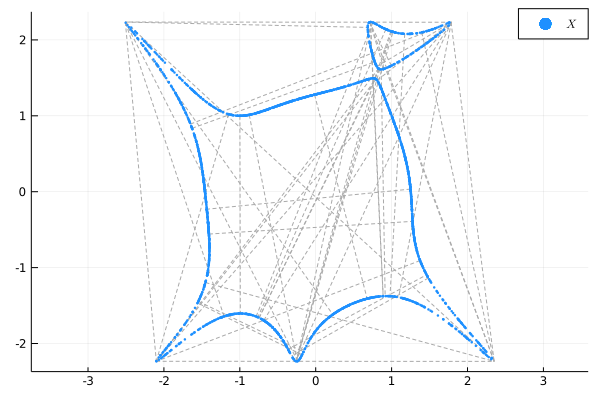

In [128]:
using Plots
plt = plot()
for bn in bottlenecks
    plot!(plt, [bn[1],bn[3]], [bn[2],bn[4]];
        legend = true, label = false, color=:darkgray, linestyle=:dash, aspect_ratio = :equal)
end
scatter!(plt, first.(samples), last.(samples);
        markerstrokewidth = 0,
        markersize=1.5,
        label = "\$X\$",
        color =:dodgerblue)

# Steiner's conic problem

In this example we consider Steiner's conic problem which states:
> How may conics are tangent to five given conics?
> -- <cite>Jakob Steiner</cite>

Steiner claimed in 1848 that there are at most 7776 conics tangent to 5 given conics. But, this is wrong.
The correct count of non-degenerate conics is **3264**.
This was shown in 1859 by [Jonquières](https://en.wikipedia.org/wiki/Ernest_de_Jonquières) and
independently in 1864 by [Chasles](https://en.wikipedia.org/wiki/Michel_Chasles).
This was also topic of the article [3264 Conics in a Second](https://www.ams.org/journals/notices/202001/rnoti-p30.pdf) by Breiding, Sturmfels and Timme which appeared in the January 2020 issue of the Notices of the AMS.

<figure>
<img src="https://www.juliahomotopycontinuation.org/images/given_conics_example.png" style="width:300px;display: block;margin-left: auto;margin-right: auto;">
<figcaption style="text-align: center;color:gray" >
The picture shows in blue the 5 given conics below. The red ellipse is tangent to the 5 blue conics.
</figcaption>
</figure>

A *conic* in the plane $\mathbb{R}^2$ is the set of solutions to a quadratic equation
$A(x,y) = 0$, where
$$
A(x,y)  =  a_1 x^2 + a_2 x y + a_3 y^2 + a_4 x + a_5 y + a_6 .
$$
If there is a second conic
$$
 U(x,y) =  u_1 x^2 +u_2 x y +u_3 y^2 + u_4 x + u_5 y + u_6,
$$
then the two conics intersect in four points in $\mathbb{C}^2$, counting multiplicities and counting intersections at points at infinity,
provided $A$ and $U$ are irreducible and not multiples of each other.
This is the content of *B\'ezout's Theorem*. To take into account the points of intersection at infinity, algebraic geometers like to replace the
affine plane $\mathbb{C}^2$ with the complex projective plane $\mathbb{P}^2_\mathbb{C}$. In the following, when we write 'count', we always mean counting solutions in projective space. Nevertheless, for our exposition we work with $\mathbb{C}^2$.

Two conics $A$ and $U$ are tangent at $(x,y)$ if $(x,y)$ is a zero of the *Jacobian determinant*

$$
\begin{matrix}
   \frac{\partial A}{ \partial x} \cdot \frac{\partial U}{\partial y} -
  \frac{\partial A}{ \partial y} \cdot \frac{\partial U}{\partial  x}\,=\,
     2 (a_1 u_2 - a_2 u_1) x^2 
    + \, 4 (a_1 u_3 - a_3 u_1) x y 
   + \,\cdots\, + (a_4 u_5 - a_5 u_4).
\end{matrix}
$$

Let's formulate these building blocks with HomotopyContinuation.jl

In [132]:
using HomotopyContinuation
@var x y
A, a = dense_poly([x,y], 2; coeff_name = :a)
@show A
U, u = dense_poly([x,y], 2; coeff_name = :u)
@show U;

A = a₆ + x*a₄ + x^2*a₁ + y*a₅ + y^2*a₃ + x*y*a₂
U = u₆ + x*u₄ + x^2*u₁ + y*u₅ + y^2*u₃ + x*y*u₂


In [137]:
jacobian_determinant = differentiate(A, x) * differentiate(U, y) - differentiate(A, y) * differentiate(U, x)

-(u₄ + 2*x*u₁ + y*u₂)*(a₅ + x*a₂ + 2*y*a₃) + (u₅ + x*u₂ + 2*y*u₃)*(a₄ + 2*x*a₁ + y*a₂)

An instance of Steiner's conic problem is now given by a list of $30 = 5 \times 6 $ coefficients in $\mathbb{R}$ or $\mathbb{C}$ representing the 5 given conics
$$
\begin{equation}
  \begin{array}{l}
   A(x,y) \,=\, a_1 x^2 + a_2 xy + a_3 y^2 + a_4 x + a_5 y + a_6 , \\[0.3em]
   B(x,y) \,=\, b_1 x^2 + b_2 xy + b_3 y^2 + b_4 x + b_5 y + b_6 , \\[0.3em]
   C(x,y) \,=\, c_1 x^2 + c_2 xy + c_3 y^2 + c_4 x + c_5 y + c_6 , \\[0.3em]
   D(x,y) \,=\, d_1 x^2 + d_2 xy + d_3 y^2 + d_4 x + d_5 y + d_6 , \\[0.3em]
   E(x,y) \,=\, e_1 x^2 + e_2 xy + e_3 y^2 + e_4 x + e_5 y + e_6 .
  \end{array}
\end{equation}
$$

A conic $U$ is then tangent to the five given conics if we can find $5$ points of tangency $p_1 ,\ldots, p_5 \in \mathbb{C}^2$ such that
$$
\begin{bmatrix}
\, A(p_1)&
U(p_1) &
(\frac{\partial A}{ \partial x}   \frac{\partial U}{\partial y} \,-\,
\frac{\partial A}{ \partial y}   \frac{\partial U}{\partial  x})(p_1) \, \\[0.5em]
\, B(p_2)&
U(p_2) &
(\frac{\partial B}{ \partial x}   \frac{\partial U}{\partial y} \,-\,
\frac{\partial B}{ \partial y}   \frac{\partial U}{\partial  x})(p_2) \, \\[0.5em]
\, C(p_3)&
U(p_3) &
(\frac{\partial C}{ \partial x}   \frac{\partial U}{\partial y} \,-\,
\frac{\partial C}{ \partial y}   \frac{\partial U}{\partial  x})(p_3) \, \\[0.5em]
\, D(p_4)&
U(p_4) &
(\frac{\partial D}{ \partial x}   \frac{\partial U}{\partial y} \,-\,
\frac{\partial D}{ \partial y}   \frac{\partial U}{\partial  x})(p_4) \, \\[0.5em]
\, E(p_5)&
U(p_5) &
(\frac{\partial E}{ \partial x}   \frac{\partial U}{\partial y} \,-\,
\frac{\partial E}{ \partial y}   \frac{\partial U}{\partial  x})(p_5) \,
\end{bmatrix} = \mathbf{0}
$$

Let's encode this this in HomotopyContinuation.jl. We start by declaring variables for the 30 coefficients of the given conics and the 5 points of tangency.

In [138]:
@var C[1:6,1:5] p[1:2,1:5];

In [17]:
C

6×5 Array{Variable,2}:
 C₁₋₁  C₁₋₂  C₁₋₃  C₁₋₄  C₁₋₅
 C₂₋₁  C₂₋₂  C₂₋₃  C₂₋₄  C₂₋₅
 C₃₋₁  C₃₋₂  C₃₋₃  C₃₋₄  C₃₋₅
 C₄₋₁  C₄₋₂  C₄₋₃  C₄₋₄  C₄₋₅
 C₅₋₁  C₅₋₂  C₅₋₃  C₅₋₄  C₅₋₅
 C₆₋₁  C₆₋₂  C₆₋₃  C₆₋₄  C₆₋₅

In [18]:
p

2×5 Array{Variable,2}:
 p₁₋₁  p₁₋₂  p₁₋₃  p₁₋₄  p₁₋₅
 p₂₋₁  p₂₋₂  p₂₋₃  p₂₋₄  p₂₋₅

For simplicity we assume only affine solutions and fix $u_6 = 1$.

In [140]:
eqs = Expression[]
for i in 1:5
    cᵢ = C[:,i]
    pᵢ = p[:,i]
    push!(eqs,
        A(a => cᵢ, [x, y] => pᵢ),
        U([x, y] => pᵢ, u[6] => 1),
        jacobian_determinant(a => cᵢ, [x, y] => pᵢ, u[6] => 1)
    )
end
steiner = System(eqs; variables = [u[1:5];vec(p)], parameters = vec(C))

System of length 15
 15 variables: u₁, u₂, u₃, u₄, u₅, p₁₋₁, p₂₋₁, p₁₋₂, p₂₋₂, p₁₋₃, p₂₋₃, p₁₋₄, p₂₋₄, p₁₋₅, p₂₋₅
 30 parameters: C₁₋₁, C₂₋₁, C₃₋₁, C₄₋₁, C₅₋₁, C₆₋₁, C₁₋₂, C₂₋₂, C₃₋₂, C₄₋₂, C₅₋₂, C₆₋₂, C₁₋₃, C₂₋₃, C₃₋₃, C₄₋₃, C₅₋₃, C₆₋₃, C₁₋₄, C₂₋₄, C₃₋₄, C₄₋₄, C₅₋₄, C₆₋₄, C₁₋₅, C₂₋₅, C₃₋₅, C₄₋₅, C₅₋₅, C₆₋₅

 C₆₋₁ + p₁₋₁*C₄₋₁ + p₁₋₁^2*C₁₋₁ + p₂₋₁*C₅₋₁ + p₂₋₁^2*C₃₋₁ + p₁₋₁*p₂₋₁*C₂₋₁
 1 + u₁*p₁₋₁^2 + u₃*p₂₋₁^2 + u₄*p₁₋₁ + u₅*p₂₋₁ + u₂*p₁₋₁*p₂₋₁
 -(u₄ + 2*u₁*p₁₋₁ + u₂*p₂₋₁)*(C₅₋₁ + p₁₋₁*C₂₋₁ + 2*p₂₋₁*C₃₋₁) + (u₅ + u₂*p₁₋₁ + 2*u₃*p₂₋₁)*(C₄₋₁ + 2*p₁₋₁*C₁₋₁ + p₂₋₁*C₂₋₁)
 C₆₋₂ + p₁₋₂*C₄₋₂ + p₁₋₂^2*C₁₋₂ + p₂₋₂*C₅₋₂ + p₂₋₂^2*C₃₋₂ + p₁₋₂*p₂₋₂*C₂₋₂
 1 + u₁*p₁₋₂^2 + u₃*p₂₋₂^2 + u₄*p₁₋₂ + u₅*p₂₋₂ + u₂*p₁₋₂*p₂₋₂
 -(u₄ + 2*u₁*p₁₋₂ + u₂*p₂₋₂)*(C₅₋₂ + p₁₋₂*C₂₋₂ + 2*p₂₋₂*C₃₋₂) + (u₅ + u₂*p₁₋₂ + 2*u₃*p₂₋₂)*(C₄₋₂ + 2*p₁₋₂*C₁₋₂ + p₂₋₂*C₂₋₂)
 C₆₋₃ + p₁₋₃*C₄₋₃ + p₁₋₃^2*C₁₋₃ + p₂₋₃*C₅₋₃ + p₂₋₃^2*C₃₋₃ + p₁₋₃*p₂₋₃*C₂₋₃
 1 + u₁*p₁₋₃^2 + u₃*p₂₋₃^2 + u₄*p₁₋₃ + u₅*p₂₋₃ + u₂*p₁₋₃*p₂₋₃
 -(u₄ + 2*u₁*p₁₋₃ + u₂*p₂₋₃)*(C

Now we want to solve a general instance of Steiner's problem. We could use as previously `solve` for this, but since the problem depends on parameters we use [`monodromy_solve`](https://www.juliahomotopycontinuation.org/guides/monodromy/).

In [142]:
generic_steiner_result = monodromy_solve(steiner; target_solutions_count = 3264)

Solutions found: 3264 	 Time: 0:00:03
  tracked loops (queued):            6525 (0)
  solutions in current (last) loop:  3258 (5)
  generated loops (no change):       2 (0)


MonodromyResult
• return_code → :success
• 3264 solutions
• 6528 tracked loops
• random_seed → 0xa254db07

Here, `monodromy_solve` generated five random conics. We can geht the coefficients of them via

In [23]:
parameters(generic_steiner_result)

30-element Array{Complex{Float64},1}:
    0.9850873546701469 + 0.22097227451098736im
    0.7058108661530634 - 0.8390965500680421im
    0.6911534466163335 - 0.7607287965445284im
   -0.2126401704195198 + 0.25907950631736193im
    0.5452449259932491 + 0.46536459210762904im
 -0.005529198833345049 + 0.05209098733732338im
   -0.0292411633699649 + 0.4199354640663881im
   -1.5518753518291486 + 1.5889195725603922im
   -1.5108926056119039 - 0.03737695751495318im
   0.38505321366526585 - 0.015296853558406862im
  -0.02766790004658232 - 0.5070774353820426im
   -0.4507783383219917 - 0.01176878769537294im
   -0.5597321219280387 + 0.9621940881896053im
                       ⋮
   0.20646291499380784 - 0.05218465211760348im
   -0.2105799499812251 + 1.4472389990183039im
   0.28978203582374024 - 0.5040160000158894im
  -0.21877274557432191 - 0.6976821062720389im
   -0.5744120710972448 - 0.18830121880880762im
    0.4670557741984469 - 0.05784033213700258im
    0.6521284900490092 - 0.07151189472915331im
   -0

### 3264 certified real conics

Now, we use these generic solutions to solve an instance for which **all** 3264 solutions are real.
[Ronga, Tognoli and Vust](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.36.1425&rep=rep1&type=pdf) showed that such instances exists, but their proof was non-construtive.
In the article [3264 Conics in a Second](https://www.ams.org/journals/notices/202001/rnoti-p30.pdf) the following concrete instance of five conics yielding 3264 real solutions was given:

In [144]:
real_conics = [
    10124547 // 662488724 520811 // 1788018449 6537193 // 241535591 13173269 // 2284890206 8275097 // 452566634
    8554609 // 755781377 2183697 // 542440933 -7424602 // 363844915 4510030 // 483147459 -19174153 // 408565940
    5860508 // 2798943247 9030222 // 652429049 6264373 // 1630169777 2224435 // 588965799 5184916 // 172253855
    -251402893 // 1016797750 -12680955 // 370629407 13097677 // 39806827 33318719 // 219393000 -23713234 // 87670601
    -25443962 // 277938473 -24872323 // 105706890 -29825861 // 240478169 92891037 // 755709662 28246737 // 81404569
    1 1 1 1 1
]

6×5 Array{Rational{Int64},2}:
   10124547//662488724      520811//1788018449  …    8275097//452566634
    8554609//755781377     2183697//542440933      -19174153//408565940
    5860508//2798943247    9030222//652429049        5184916//172253855
 -251402893//1016797750  -12680955//370629407      -23713234//87670601
  -25443962//277938473   -24872323//105706890       28246737//81404569
          1//1                   1//1           …          1//1

We can use our generic result to compute the 3264 solutions via a [parameter homotopy](https://www.juliahomotopycontinuation.org/guides/parameter-homotopies/).

In [145]:
S = solutions(generic_steiner_result)
real_steiner_result = solve(steiner, S;
        start_parameters = parameters(generic_steiner_result),
        target_parameters = vec(real_conics))

Tracking 3264 paths... 100%|████████████████████████████| Time: 0:00:01
  # paths tracked:                  3264
  # non-singular solutions (real):  3264 (3264)
  # singular endpoints (real):      0 (0)
  # total solutions (real):         3264 (3264)


Result with 3264 solutions
• 3264 paths tracked
• 3264 non-singular solutions (3264 real)
• random_seed: 0xeb6f0bdb


We can now also **certify** that these are 3264 distinct, real solutions. This can either be accomplished via [alphaCertified](https://www.math.tamu.edu/~frank.sottile/research/stories/alphaCertified/index.html) developed by Hauenstein and Sottile or by using the new certification capabilities of HomotopyContinuation.jl. There, the certification is performed using *interval arithmetic* and the Krawczyk method.

In [147]:
steiner_cert = certify(steiner, real_steiner_result, vec(real_conics))

Certifying 3264 solutions... 100%|██████████████████████| Time: 0:00:00
  # solutions considered:        3264
  # certified solutions (real):  3264 (3264)


CertificationResult
• 3264 solutions given
• 3264 certified solutions (3264 real)
• 3264 distinct certified solutions (3264 real)

We can also save our certificate to disk

In [74]:
# save to disk
save("steiner_cert.txt", steiner_cert)

"steiner_cert.txt"

In [82]:
# read first 80 lines of file to show what we wrote
open("steiner_cert.txt") do f
    for l in Iterators.take(readlines(f), 80)
        println(l)
    end
end

## Summary
CertificationResult
• 3264 solutions given
• 3264 certified solutions (3264 real)
• 3264 distinct certified solutions (3264 real)

## Certificates
index = 1
initial_solution = [
  -0.03641867042067688 - 4.0049206555467365e-31im,
  0.03352121872478268 - 9.258208788502897e-32im,
  -0.02135309444972149 + 3.3370388547456866e-31im,
  -0.068891228166562 - 1.7403241471445175e-30im,
  0.03252411222135567 + 1.1202694763451267e-30im,
  5.437850458268604 - 3.7907141709158844e-29im,
  7.068029874458393 + 9.931425302402442e-29im,
  1.2588060657261884 - 1.7469116508705651e-28im,
  8.31691785305827 + 2.537401569798681e-29im,
  -5.531862086946251 + 1.8472019743122412e-30im,
  1.4500725151724922 + 4.88141017423313e-30im,
  -6.835505008226431 + 3.664152117202398e-29im,
  -7.827095273740065 - 4.440313188344132e-29im,
  1.3516082527854283 - 1.3427445686780457e-32im,
  -4.7102453445438925 - 8.305117381109011e-33im,
]
certified_solution = [
  (-0.036418670423523064 ± 5.759281940243e-15) + (0.0 ± 

### How rare are many real solutions?

After finding a fully real instance, let's investigate what the "common" number of real solutions is.
For this we start with a small set of sample coefficients.

In [149]:
n_samples = 50
# This computes the solution for `n_samples` parameter values and stores the number of real solutions.
steiner_real_sample_result =
    solve(steiner, solutions(generic_steiner_result);
            start_parameters = parameters(generic_steiner_result),
            target_parameters = [randn(30) for _ in 1:n_samples],
            transform_result = (R, p) -> nreal(R))

Solving for 50 parameters... 100%|██████████████████████| Time: 0:00:32
  # parameters solved:  50
  # paths tracked:      163200


50-element Array{Int64,1}:
 132
 146
   0
 132
  94
 124
   0
   0
   0
 130
 138
 214
 132
   ⋮
 190
 172
   0
 216
   0
 190
 126
   0
   0
 154
 132
 100

Let's make an histogram and show some basic statistics

min: 0 max: 252 mean: 91.12 median: 122.0


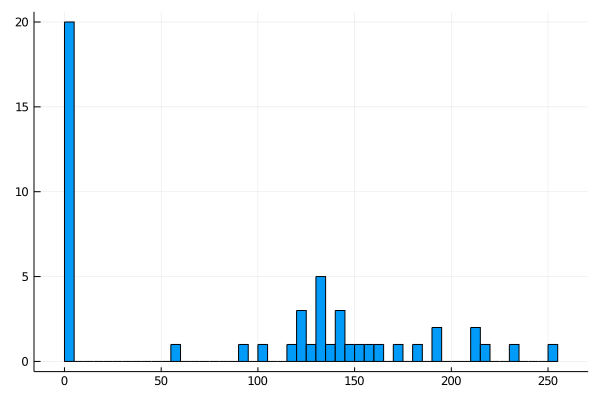

In [151]:
using Statistics, Plots
let s = steiner_real_sample_result
    println("min: ", minimum(s), " max: ", maximum(s), " mean: ", mean(s), " median: ", median(s))
end
histogram(steiner_real_sample_result, nbins = n_samples, legend = false)

# Gaussian mixtures and the method of moments

This example is from the article [Moment Varieties of Gaussian Mixtures](https://arxiv.org/abs/1510.04654) by Amendola, Faugere and Sturmfels.


Consider two Gaussian random variables $X_1$ and $X_2$ with means $\mu_1,\mu_2$ and variances $\sigma_1^2,\sigma_2^2$. The density of $X_i$ is

$$\phi_i(x) = \frac{1}{\sqrt{2\pi}} e^{-\frac{(x-\mu_i)^2}{2\sigma_i^2}}.$$

A mixture of the two random variables is the random variable $U$ with density

$$\psi(x) = a_1 \phi_1(x) + a_2 \phi_2(x), \quad\text{   for } \quad  a_1+a_2 =1.$$

Let's illustrate this on an example. We take $\mu_1 = 0, \mu_2 = -2, \sigma_1 = 0.75, \sigma_2 = 0.5$ and $a_1 = 0.35, a_2 = 0.65$.

In [586]:
using Distributions: Categorical, Normal

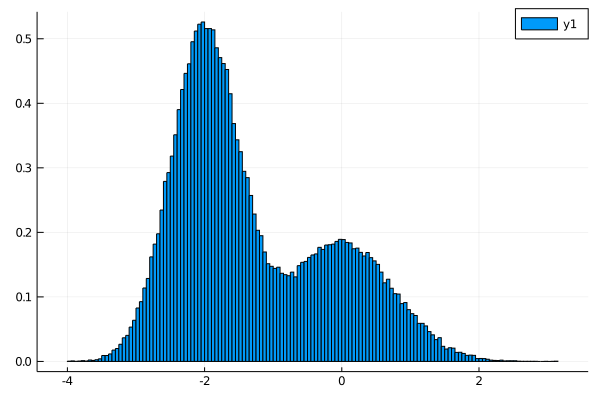

In [601]:
X₁ = Normal(0.0, 0.75)
X₂ = Normal(-2, 0.5)
a₁ = 0.35
a₂ = 0.65
mixture_sampler = let X = [X₁, X₂], α = Categorical([a₁, a₂])
    () -> rand(X[rand(α)])
end
mixture_samples = [mixture_sampler() for _ in 1:100_000];
histogram(mixture_samples, normalize = true, nbins = 200)

The [method of moments](https://en.wikipedia.org/wiki/Method_of_moments_(statistics)) recovers $\psi$ from the moments

  $$m_k = \int x^k \psi(x) \mathrm{d}x.$$
  
Since we have 6 unknowns, we expect to need at least the moments $m_0, \ldots, m_5$ to recover $\psi$.

We compute the sample moments $\hat{m}_0, \ldots, \hat{m}_5$ from our examples.

In [604]:
N = length(mixture_samples)
m̂ = [sum(x^k / (factorial(k) * N) for x in mixture_samples) for k in 0:5]

6-element Array{Float64,1}:
  0.9999999999980838
 -1.296413679696586
  1.4773193465363406
 -1.0265463667167947
  0.6138073783464579
 -0.29141421383553867

Let's use HomotopyCotinuation.jl to recover our choosen parameters with the method of moments.

The moments generating function for a mixture of three Gaussian random variables is 
$$
\sum_{i=0}^{\infty} \frac{m_i}{i!}t^i = a_1 \exp(\mu_1 + \frac12 \sigma_1^2 t^2) + a_2 \exp(\mu_2 + \frac12 \sigma_2^2 t^2)
$$
We obtain the necessary identities for $m_0, \ldots, m_8$ by considering the first 9 coefficients of the right hand side.

In [605]:
using HomotopyContinuation
@var μ σ² t

exp_trunc = sum(0:5) do k
    (μ * t + σ² * t^2)^k / factorial(k)
end
moments = reverse(coefficients(exp_trunc, t))[1:6]

6-element Array{Expression,1}:
                                         1
                                         μ
                            σ² + (1/2)*μ^2
                          μ*σ² + (1/6)*μ^3
    (1/2)*μ^2*σ² + (1/24)*μ^4 + (1/2)*σ²^2
 (1/2)*μ*σ²^2 + (1/6)*μ^3*σ² + (1/120)*μ^5

Now, that we have the moment identities, let's setup the system.

In [609]:
@var a₁ a₂ μ₁ μ₂ s₁ s₂ m[0:5]
eqs = a₁ .* moments(μ => μ₁, σ² => s₁) + a₂ .* moments(μ => μ₂, σ² => s₂)  - m
mixture_system = System(eqs; variables = [a₁, μ₁, s₁, a₂, μ₂, s₂], parameters = m)

System of length 6
 6 variables: a₁, μ₁, s₁, a₂, μ₂, s₂
 6 parameters: m₀, m₁, m₂, m₃, m₄, m₅

 a₁ + a₂ - m₀
 -m₁ + a₁*μ₁ + a₂*μ₂
 -m₂ + a₁*(s₁ + (1/2)*μ₁^2) + a₂*(s₂ + (1/2)*μ₂^2)
 -m₃ + a₁*(s₁*μ₁ + (1/6)*μ₁^3) + a₂*(s₂*μ₂ + (1/6)*μ₂^3)
 -m₄ + a₁*((1/2)*s₁*μ₁^2 + (1/2)*s₁^2 + (1/24)*μ₁^4) + a₂*((1/2)*s₂*μ₂^2 + (1/2)*s₂^2 + (1/24)*μ₂^4)
 -m₅ + a₁*((1/6)*s₁*μ₁^3 + (1/2)*s₁^2*μ₁ + (1/120)*μ₁^5) + a₂*((1/6)*s₂*μ₂^3 + (1/2)*s₂^2*μ₂ + (1/120)*μ₂^5)

In [613]:
recovered_result = solve(mixture_system, target_parameters = m̂)

Result with 18 solutions
• 35 paths tracked
• 18 non-singular solutions (6 real)
• random_seed: 0x4f5b133b
• start_system: :polyhedral


We obtain $6$ real solutions, let's see how many have real variances:

In [617]:
filter(real_solutions(recovered_result)) do x
    x[3] > 0 && x[6] > 0
end

2-element Array{Array{Float64,1},1}:
 [0.3502072014025049, 0.004492006318944065, 0.2824840381566238, 0.6497927985955788, -1.9975395471658235, 0.12619080115383313]
 [0.6497927985955788, -1.9975395471658235, 0.12619080115383313, 0.3502072014025049, 0.004492006318944065, 0.2824840381566238]

Exactly the 2 solutions corresponding to our orignal parameters!

# The degree of Stiefel manifolds

Here, we show how HomotopyContinuation.jl can be used to compute the degree of irreducible varieties.
As an example we take the recent article [The Degree of Stiefel Manifolds](https://arxiv.org/abs/1909.10085) by Taylor Brysiewicz and Fulvio Gesmundo.

The Stiefel manifold $\textrm{St}(k, n)$, $k \le n$, is defined by
$$\textrm{St}(k, n) = \{ A \in \textrm{Mat}_{k \times n}(\mathbb{C})\ \, | \, A A^T = \textrm{id}_k\}\,.$$
If $k < n$ then this is an irreducible variety.
We want to compute the degree of $\textrm{St}(4, 5)$.

In [619]:
using HomotopyContinuation, LinearAlgebra

function stiefel(k, n)
    @var A[1:k,1:n]
    id = A * A' - LinearAlgebra.I
    System([id[i,j] for i in 1:k for j in i:k])
end

stiefel (generic function with 1 method)

In [620]:
stiefel(4, 5)

System of length 10
 20 variables: A₁₋₁, A₂₋₁, A₃₋₁, A₄₋₁, A₁₋₂, A₂₋₂, A₃₋₂, A₄₋₂, A₁₋₃, A₂₋₃, A₃₋₃, A₄₋₃, A₁₋₄, A₂₋₄, A₃₋₄, A₄₋₄, A₁₋₅, A₂₋₅, A₃₋₅, A₄₋₅

 -1 + A₁₋₁^2 + A₁₋₂^2 + A₁₋₃^2 + A₁₋₄^2 + A₁₋₅^2
 A₁₋₁*A₂₋₁ + A₁₋₂*A₂₋₂ + A₁₋₃*A₂₋₃ + A₁₋₄*A₂₋₄ + A₁₋₅*A₂₋₅
 A₁₋₁*A₃₋₁ + A₁₋₂*A₃₋₂ + A₁₋₃*A₃₋₃ + A₁₋₄*A₃₋₄ + A₁₋₅*A₃₋₅
 A₁₋₁*A₄₋₁ + A₁₋₂*A₄₋₂ + A₁₋₃*A₄₋₃ + A₁₋₄*A₄₋₄ + A₁₋₅*A₄₋₅
 -1 + A₂₋₁^2 + A₂₋₂^2 + A₂₋₃^2 + A₂₋₄^2 + A₂₋₅^2
 A₃₋₁*A₂₋₁ + A₃₋₂*A₂₋₂ + A₃₋₃*A₂₋₃ + A₃₋₄*A₂₋₄ + A₃₋₅*A₂₋₅
 A₂₋₁*A₄₋₁ + A₂₋₂*A₄₋₂ + A₂₋₃*A₄₋₃ + A₂₋₄*A₄₋₄ + A₂₋₅*A₄₋₅
 -1 + A₃₋₁^2 + A₃₋₂^2 + A₃₋₃^2 + A₃₋₄^2 + A₃₋₅^2
 A₃₋₁*A₄₋₁ + A₃₋₂*A₄₋₂ + A₃₋₃*A₄₋₃ + A₃₋₄*A₄₋₄ + A₃₋₅*A₄₋₅
 -1 + A₄₋₁^2 + A₄₋₂^2 + A₄₋₃^2 + A₄₋₄^2 + A₄₋₅^2

The dimension of the Stiefel manifold is also known.

In [621]:
dim_stiefel(k, n) = binomial(n, 2) - binomial(n - k, 2)

dim_stiefel (generic function with 1 method)

Since $\textrm{St}(4, 5)$ is irreducible, we can use `monodromy_solve` to compute it's degree. If `monodromy_solve` is given a system and a dimension or codimension, it intersects the system with a random linear space and moves it around in loops to find new solutions. Additionally, a trace test is performed to determine when the computation is done.

In [623]:
monodromy_solve(stiefel(4, 5), dim = dim_stiefel(4, 5))

Solutions found: 384 	 Time: 0:00:01
  tracked loops (queued):            1152 (0)
  solutions in current (last) loop:  0 (0)
  generated loops (no change):       3 (1)


MonodromyResult
• return_code → :success
• 384 solutions
• 1152 tracked loops
• random_seed → 0x44c64c4d
• trace → 1.6647140472206523e-12

And we see, that the degree of the Stiefel manifold $\textrm{St}(4, 5)$ is $384$.

# Tritangent planes to a quartic surface

Here, we consider a classic problem from algebraic geometry.
How many tritangent planes does a general quartic surface $X \subset \mathbb{P}^3$ have where a tritangent plane is a linear space $L \subset \mathbb{P}^3$ which is tanget to $X$ at 3 distinct points.
We can encode this problem by requiring that 3 points vanish on our quartic surface, and that their normale spaces coincide.

In [627]:
using HomotopyContinuation

tritangents_system = let
    @var x[1:4]

    # declare the variables for the 3 points
    @var p[1:3, 1:3] u v

    p₁, p₂, p₃ = [p[:, 1]; 1], [p[:, 2]; 1], [p[:, 3]; 1]

    # construct a general quartic surface
    f, c = dense_poly(x, 4; homogeneous = true, coeff_name = :c)
    ∇f = differentiate(f, x)
    System([
        f(x => p₁)
        f(x => p₂)
        f(x => p₃)
        ∇f(x => p₁) - u * ∇f(x => p₂)
        ∇f(x => p₁) - v * ∇f(x => p₃)
    ], parameters = c)
end;

Our formulation of the problem has a small flaw. We can just permute the 3 points to create another solution, but this still gives us the same tritangent plane.
If we use `monodromy_solve` to compute the number of tritangent planes then we can tell HomotopyContinuation.jl to consider them as a single solution.

In [ ]:
# An S₃ is acting on our solutions (by permuting the points), let's teach the programm how to
# make out of one solution the 5 other ones.
tritangents_relabeling = let S₃ = SymmetricGroup(3)
    s -> map(S₃) do perm
        p = ((s[1], s[2], s[3]), (s[4], s[5], s[6]), (s[7], s[8], s[9]))
        w = (1, s[10], s[11])
        i, j, k = perm
        [p[i]..., p[j]..., p[k]..., w[j] / w[i], w[k] / w[i]]
    end
end

In [ ]:
monodromy_solve(tritangents_system, group_action = tritangents_relabeling)

We see that there are $3200$ tritangent planes to a general quartic surface.

# Witness sets

Witness sets allow use to work with positive dimensional components of algebraic varieties and are one of the building blocks of algorithms in numerical algebraic geometry.

Here we want to illustrate this on a simple example. We intersect a general cubic surface in $\mathbb{P}^3$ with a general quadratic_surface in $\mathbb{P}$ resulting in a sextic space curve.
A witness for this curve now consists of a linear space $L$, 6 solutions points (corresponding to its degree) and the defininig equations of the system.

In [6]:
using HomotopyContinuation
@var x y z w

cubic_surface = rand_poly([x,y,z,w], 3; homogeneous = true)
quadratic_surface = rand_poly([x,y,z,w], 2; homogeneous = true)
sextic_space_curve = System([cubic_surface, quadratic_surface])
W = witness_set(sextic_space_curve; compile = false)

Tracking 6 paths... 100%|███████████████████████████████| Time: 0:00:04
  # paths tracked:                  6
  # non-singular solutions (real):  6 (0)
  # singular endpoints (real):      0 (0)
  # total solutions (real):         6 (0)


Witness set for dimension 1 of degree 6

In [8]:
system(W)

Interpreted: System of length 2
 4 variables: w, x, y, z

 w*(w*((-0.368281688904475 - 0.205498696142613*im)*w + (-0.534720811552487 - 0.354631175658608*im)*x + (-0.415356232739963 + 0.405288598876581*im)*y + (-0.346205564638789 - 0.205737203499279*im)*z) + x*((-0.149329164887402 + 0.512529307864659*im)*x + (0.665638032791266 - 0.0387208065255731*im)*y + (-0.0978624833636384 - 0.948771445850193*im)*z) + y*((-0.193794927078123 - 0.0763613665282127*im)*y + (-0.623919063417763 + 1.01941067610735*im)*z) + (0.116348526703093 + 0.502557002012443*im)*z^2) + x*(x*((-0.652366295616623 + 0.835858850119577*im)*x + (-0.616211947458883 + 0.383229382460718*im)*y + (-0.0968545381049841 - 0.578100875182333*im)*z) + y*((0.183394531191564 - 0.616998833860484*im)*y + (0.549238824726249 + 0.0289792703248567*im)*z) + (-0.625637184014393 - 0.261803655109272*im)*z^2) + y*(y*((-0.538043959973708 + 1.04804718483738*im)*y + (-0.953630089137546 - 1.16955788370669*im)*z) + (0.199688563090251 + 0.801149893565506*i

In [12]:
linear_subspace(W)

3-dim. linear subspace {x | Ax=0} with eltype Complex{Float64}:
A:
Complex{Float64}[-0.07006281011516702 - 0.20690819773949226im -0.509322234638196 - 0.5667704766192296im 0.37755087250971103 - 0.12913463060484542im 0.09782960835367277 - 0.4503900998667708im]

In [11]:
solutions(W)

6-element Array{Array{Complex{Float64},1},1}:
 [0.3749131146988339 - 0.5749712229224063im, 0.25829158290015247 + 0.11126094732480915im, 0.07385305964227495 + 0.11574522244068844im, -0.35846131980972773 + 0.4573059639556394im]
 [0.31666363895477645 + 0.5550444155673192im, 0.385023886462034 - 0.07965423248814084im, 0.08581962160252045 - 0.345010004000256im, -0.82369032664193 + 0.5358083288433066im]
 [-1.0787925878494258 - 0.7874652116172249im, 1.188106179925856 - 0.5452334650186806im, 1.024198523941141 + 0.6872248713536249im, 0.2632727250253967 + 1.1108446859589332im]
 [0.08222447523049443 - 0.10798178234842412im, 0.020183901623754767 - 0.32707305125144626im, 0.44658591450494844 - 0.20431841538653325im, 0.06063603500241494 + 0.16785967250588973im]
 [-0.18171531290243978 - 0.22258576556148238im, -0.40940445116656526 + 0.17197001678467136im, 0.37739667437601393 - 0.47683451441001456im, -0.2288202032978894 - 0.7353362967463806im]
 [0.9724933997586306 - 0.08871492047245193im, -0.243829210461

We can also move the linear subspace to obtain a new witness set.

In [14]:
L = rand_subspace(4, codim = 1, affine = false)

3-dim. linear subspace {x | Ax=0} with eltype Complex{Float64}:
A:
Complex{Float64}[-0.741878157687949 + 0.1241808494362895im 0.17565436626255868 - 0.12369950184424981im 0.09605042782721837 + 0.5295215725128237im 0.3085989224251946 - 0.05646075868214345im]

In [19]:
W′ = witness_set(W, L)

Witness set for dimension 1 of degree 6

We can also perform a *trace test* which returns (theoretically) 0 if `W′` is complete.

In [20]:
trace_test(W′)

7.49675440874447e-16